In [31]:
import mitiq

mitiq.SUPPORTED_PROGRAM_TYPES.keys()

dict_keys(['cirq', 'pyquil', 'qiskit', 'braket', 'pennylane', 'qibo'])

In [32]:
#We first define the circuit of interest. In this example, the circuit has a slack window 
#with a length of 4 (in the sense that 4 single-qubit gates can fit in that window).

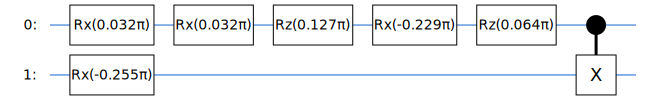

In [33]:
from cirq import LineQubit, Circuit, rx, rz, CNOT
from cirq.contrib.svg import SVGCircuit

a, b = LineQubit.range(2)
#cirq.NamedQubit: used to label qubits by an abstract name.
#cirq.LineQubit: qubits labelled by number in a linear array.
#cirq.GridQubit: qubits labelled by two numbers in a rectangular lattice.
circuit = Circuit(
    rx(0.1).on(a),
    rx(0.1).on(a),
    rz(0.4).on(a),
    rx(-0.72).on(a),
    rz(0.2).on(a),
    rx(-0.8).on(b),
    CNOT.on(a, b),
)
SVGCircuit(circuit)
#The Rx gate is one of the Rotation operators. The Rx gate is a single-qubit rotation through angle θ (radians) around the x-axis.
#Ry-- y axis and Rz -- z axis
#The angle of rotation must be specified in radians and can be positive or negative.

#The CNOT gate is two-qubit operation, where the first qubit is usually referred to as the control qubit and the second qubit as the target qubit. Expressed in basis states, the CNOT gate:
#leaves the control qubit unchanged and performs a Pauli-X gate on the target qubit when the control qubit is in state ∣1⟩
#leaves the target qubit unchanged when the control qubit is in state ∣0⟩.

In [34]:
#Error mitigation methods can involve running many circuits.  
#The mitiq.Executor classis a tool for efficiently running many circuits and storing the results.

#Next we define a simple executor function which inputs a circuit, executes the circuit on a noisy simulator, 
#and returns the probability of the ground state.

In [35]:
import numpy as np
from cirq import DensityMatrixSimulator, amplitude_damp
from mitiq.interface import convert_to_mitiq
#A density matrix is a matrix that describes a quantum system in a mixed state, a statistical ensemble of several quantum states.

#cirq.AmplitudeDampingChannel (or cirq.amplitude_damp) performs a /1>--->/0>
#transformation with some probability gamma, leaving the existing /0>state alone.
#  This channel is best used to represent an idealized form of energy dissipation, where qubits decay from to ∣1⟩ to /0>

def execute(circuit, noise_level=0.1):
    #we can change the noise level from 0 to 1 and compare the efficiency of the DD for different noise level
    #In the theory of quantum communication, an amplitude damping channel 
    #is a quantum channel that models physical processes such as spontaneous emission.
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit
    executed with amplitude damping noise.
    """
    # Replace with code based on your frontend and backend.
    mitiq_circuit, _ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(amplitude_damp(gamma=noise_level)) 
    #we can change gamma level and check the circuit
    rho = DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix
    return rho[0, 0].real #this will return real values 
#rho[0,0] represents the first row first column of the density matrix

In [36]:
#The executor can be used to evaluate noisy (unmitigated) expectation values.

In [37]:
# Compute the expectation value of the |0><0| observable.
noisy_value = execute(circuit)
ideal_value = execute(circuit, noise_level=0.0) #ideal noise leve=zero noise=0.0
print(f"Error without mitigation: {abs(ideal_value - noisy_value) :.3}") #.3-upto 3 nonzero digits

Error without mitigation: 0.0753


In [38]:
#Select the DDD sequences to be applied
#We now import a DDD rule from Mitiq, i. e., 
#a function that generates DDD sequences of different length. 
#In this example, we opt for YY sequences (pairs of Pauli Y operations).

In [39]:
from mitiq import ddd

rule = ddd.rules.yy

In [40]:
#Mitiq provides basic built in rules to approximate dynamical decoupling sequences
#that are most used and discussed in the literature .
#For example, the XX, YY, and XYXY rules generate the corresponding gate sequences spaced evenly over the input slack window.

#For each of these rules, the user may specify a different spacing between the gates in the sequence 
#and pass the desired option as shown in the next code cell.

#Note thatif we have defines for odd number of slack window and the dd sequence we use is even, 
#the remaining will take identity gate

In [41]:
#Digital dynamical decoupling can be easily implemented with the function execute_with_ddd().

In [42]:
mitigated_result = ddd.execute_with_ddd(
    circuit=circuit,
    executor=execute,
    rule=rule,
)

In [43]:
print(f"Error with mitigation (DDD): {abs(ideal_value - mitigated_result) :.3}")


Error with mitigation (DDD): 0.00743


In [44]:
#here we can use different noise levels , different DDD rules , differnt circuits and compare them all.
#We are using gate delay , we can also insert delays between gates , increase the number of ddd sequence , we can change the 
#time duration between gates or between sequences and compare theresults.

In [45]:
#Here we observe that the application of DDD reduces the estimation error when compared to the unmitigated result.

#DDD is designed to mitigate noise that has a finite correlation time.
#For the simple Markovian noise simulated in this example, DDD can still have a non-trivial effect on the final error,
#but it is not always a positive effect. 
#For example, one can check that by changing the parameters of the input circuit, 
#the error with DDD is sometimes larger than the unmitigated error.